<a href="https://colab.research.google.com/github/tugberkcapraz/MRP-with-pymc3/blob/master/mrpPymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756051 sha256=25c987162134b01aa48a460448d29079d105df4e9a64504051b286541e7b880f
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_q3m8vc/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
!pip install arviz
!pip install us
import os
import us
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.patches import Polygon
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared

     |████████████████████████████████| 133kB 3.4MB/s 
  Created wheel for us: filename=us-1.0.0-cp36-none-any.whl size=11833 sha256=3b5fcf70e4c6e995f6f47634043f10972f022f335dee975658dea0e788547511
  Stored in directory: /root/.cache/pip/wheels/b3/98/40/cb8be35d7779a0ae4372c84e7a585c947bfc41540fd8999e53
  Created wheel for jellyfish: filename=jellyfish-0.5.6-cp36-cp36m-linux_x86_64.whl size=74548 sha256=e22d39b3d1d8ee81ab7368ac8167d22d530edb977f40d7cd900a7a1a99ce704c
  Stored in directory: /root/.cache/pip/wheels/3b/29/06/8d686d24f742cb89e7bde7f26f18cb9e89b3c8bcd6999cb12a
Successfully built us jellyfish


In [0]:
%%bash
if [ ! -e ./st99_d00.dbf ];
then
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.dbf
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shp
    wget -q https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shx
fi

In [0]:
SEED = 4260026 # from random.org, for reproducibility

np.random.seed(SEED)

In [0]:
def to_zero_indexed(col):
    return lambda df: (df[col] - 1).astype(np.int64)



In [0]:
survey_df = pd.read_stata("/content/drive/My Drive/MRP_Primer_Replication_Files/gay_marriage_megapoll.dta",
                           columns=['race_wbh', 'age_cat', 'edu_cat', 'female',
                                    'state_initnum', 'state', 'region_cat', 'region', 'statename',
                                    'poll', 'yes_of_all']).dropna(subset=['race_wbh', 'age_cat', 'edu_cat', 'state_initnum']).assign(state_initnum=to_zero_indexed('state_initnum'),
                       race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat'),
                       region_cat=to_zero_indexed('region_cat'))

In [14]:
survey_df.head()

,race_wbh,age_cat,edu_cat,female,state_initnum,state,region_cat,region,statename,poll,yes_of_all
0,0,2,2,1,22,MI,1,midwest,michigan,Gall2005Aug22,0
1,0,2,3,0,10,GA,2,south,georgia,Gall2005Aug22,0
2,2,0,3,0,34,NY,0,northeast,new york,Gall2005Aug22,1
3,0,3,3,1,30,NH,0,northeast,new hampshire,Gall2005Aug22,1
5,0,3,2,1,14,IL,1,midwest,illinois,Gall2005Aug22,0


In [15]:
survey_df.shape[0]

6341

In [0]:
def state_plot(state_data, cmap, norm, cbar=True, default=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = plt.gcf()

    m = Basemap(llcrnrlon=-121, llcrnrlat=20,
                urcrnrlon=-62, urcrnrlat=51,
                projection='lcc',
                lat_1=32, lat_2=45, lon_0=-95)
    m.readshapefile('st99_d00', name='states', drawbounds=True)

    for state_info, state_seg in zip(m.states_info, m.states):
        if state_info['NAME'] == 'Alaska':
            state_seg = list(map(lambda xy: (0.35 * xy[0] + 1100000, 0.35 * xy[1] - 1300000), state_seg))
        elif state_info['NAME'] == 'Hawaii' and float(state_info['AREA']) > 0.005:
            state_seg = list(map(lambda xy: (xy[0] + 5100000, xy[1] - 1400000), state_seg))

        try:
            state_datum = state_data.loc[us.states.lookup(state_info['NAME']).abbr]   
        except KeyError:
            state_datum = default
        
        if state_datum is not None:
            color = rgb2hex(cmap(norm(state_datum))) 

            poly = Polygon(state_seg, facecolor=color, edgecolor='#000000')
            ax.add_patch(poly)
    
    if cbar:
        cbar_ax = fig.add_axes([0.925, 0.25, 0.04, 0.5])
        mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    else:
        cbar_ax = None
        
    return fig, ax, cbar_ax

In [0]:
state_counts = survey_df.groupby('state').size()


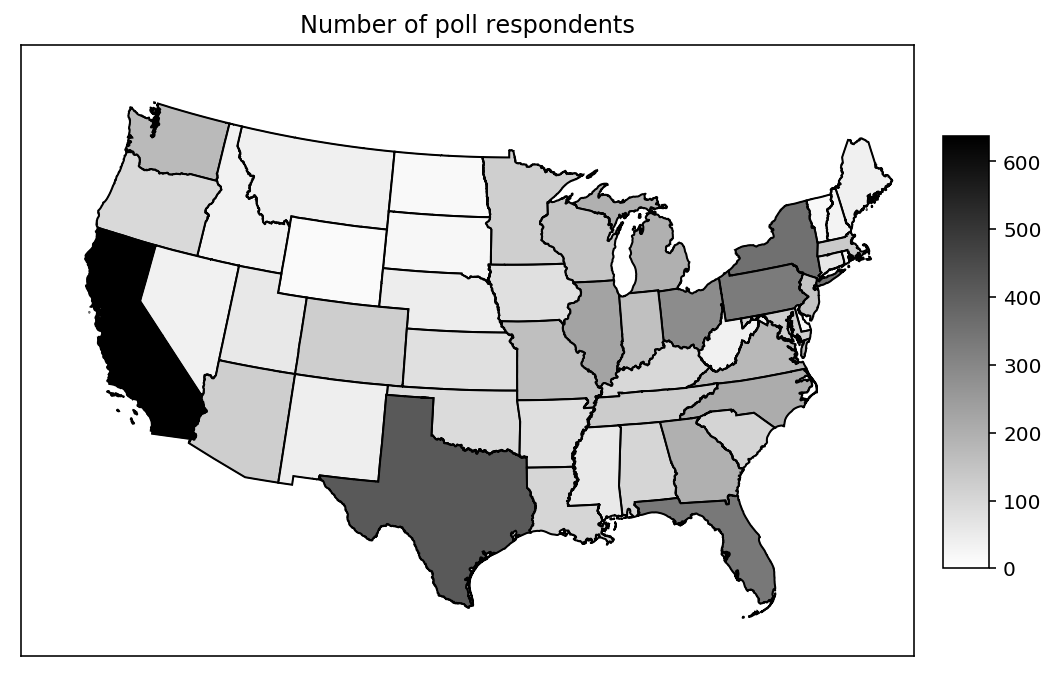

In [18]:
fig, ax, cbar_ax = state_plot(state_counts,
                              mpl.cm.binary,
                              Normalize(0, state_counts.max()),
                              default=None)

ax.set_title("Number of poll respondents");

In [0]:
disagg_p = (survey_df.groupby('state')
                     .yes_of_all
                     .mean())

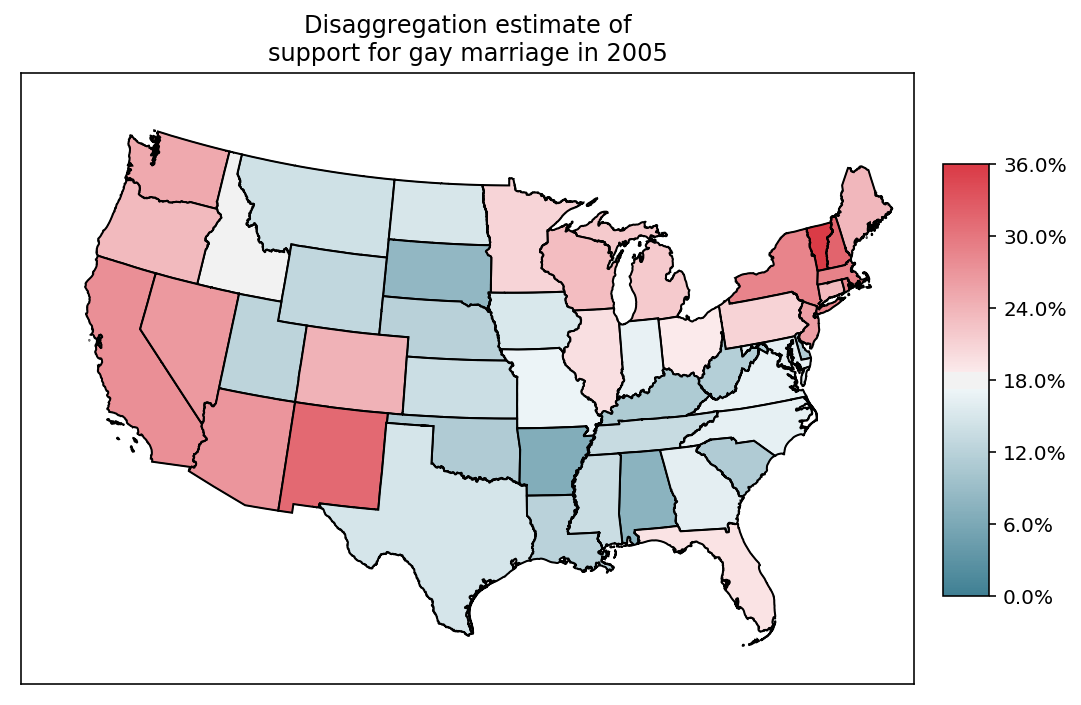

In [20]:
p_norm = Normalize(0., 0.6)
p_cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax, cbar_ax = state_plot(disagg_p, p_cmap, p_norm)

p_formatter = FuncFormatter(lambda prop, _: '{:.1%}'.format(p_norm.inverse(prop)))
cbar_ax.yaxis.set_major_formatter(p_formatter);

ax.set_title("Disaggregation estimate of\nsupport for gay marriage in 2005");


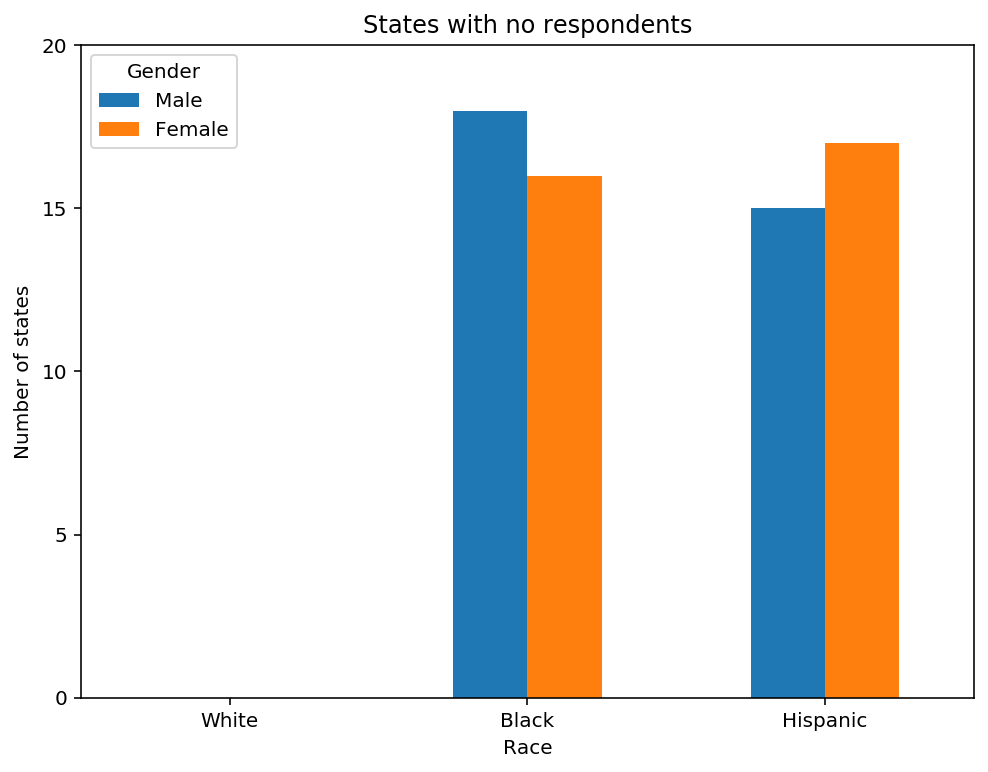

In [21]:
ax = (survey_df.groupby(['state', 'female', 'race_wbh'])
               .size()
               .unstack(level=['female', 'race_wbh'])
               .isnull()
               .sum()
               .unstack(level='female')
               .rename(index={0: 'White', 1: 'Black', 2: 'Hispanic'},
                       columns={0: 'Male', 1: 'Female'})
               .rename_axis('Race', axis=0)
               .rename_axis('Gender', axis=1)
               .plot(kind='bar', rot=0, figsize=(8, 6)))

ax.set_yticks(np.arange(0, 21, 5));
ax.set_ylabel("Number of states");

ax.set_title("States with no respondents");

In [22]:
uniq_survey_df = (survey_df.groupby(['race_wbh', 'female', 'edu_cat', 'age_cat',
                                     'region_cat', 'state_initnum', 'poll'])
                           .yes_of_all
                           .agg({
                               'yes_of_all': 'sum',
                               'n': 'size'
                           })
                           .reset_index())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


In [23]:
uniq_survey_df.head()


,race_wbh,female,edu_cat,age_cat,region_cat,state_initnum,poll,yes_of_all,n
0,0,0,0,0,0,6,Pew 2004Dec01,0,1
1,0,0,0,0,0,30,Gall2005Aug22,0,1
2,0,0,0,0,0,34,ABC 2004Jan15,1,1
3,0,0,0,0,0,38,Pew 2004Dec01,1,1
4,0,0,0,0,1,12,ABC 2004Jan15,0,1


In [24]:
uniq_survey_df.shape[0] / survey_df.shape[0]


0.5824002523261316

In [0]:
def encode_gender_race(female, race_wbh):
    return (3 * female + race_wbh).values

def encode_age_edu(age, edu):
    return (4 * age + edu).values

In [0]:
gender_race = encode_gender_race(uniq_survey_df.female, uniq_survey_df.race_wbh)
n_gender_race = np.unique(gender_race).size

age = uniq_survey_df.age_cat.values
n_age = np.unique(age).size

edu = uniq_survey_df.edu_cat.values
n_edu = np.unique(edu).size

age_edu = encode_age_edu(uniq_survey_df.age_cat, uniq_survey_df.edu_cat)
n_age_edu = np.unique(age_edu).size

poll, poll_map = uniq_survey_df.poll.factorize()
n_poll = poll_map.size

region = uniq_survey_df.region_cat.values
n_region = np.unique(region).size

state = uniq_survey_df.state_initnum.values
n_state = 51

n = uniq_survey_df.n.values
yes_of_all = uniq_survey_df.yes_of_all.values

In [0]:
state_df = (pd.read_stata("/content/drive/My Drive/MRP_Primer_Replication_Files/state_level_update.dta",
                          columns=['sstate_initnum', 'sstate',
                                   'p_evang', 'p_mormon', 'kerry_04'])
              .rename(columns={'sstate_initnum': 'state_initnum', 'sstate': 'state'})
              .assign(state_initnum=to_zero_indexed('state_initnum'),
                      p_relig=lambda df: df.p_evang + df.p_mormon))

In [28]:
state_df.head()


,state_initnum,state,p_evang,p_mormon,kerry_04,p_relig
0,0,AK,12.440000,3.003126,35.500000,15.443126
1,1,AL,40.549999,0.458273,36.799999,41.008274
2,2,AR,43.070000,0.560113,44.599998,43.630112
3,3,AZ,9.410000,4.878735,44.400002,14.288734
4,4,CA,7.160000,1.557627,54.299999,8.717627


In [0]:
state_kerry = sp.special.logit(state_df.kerry_04.values / 100.)
state_relig = sp.special.logit(state_df.p_relig.values / 100.)

In [0]:
census_df = (pd.read_stata("/content/drive/My Drive/MRP_Primer_Replication_Files/poststratification 2000.dta")
               .rename(columns=lambda s: s.lstrip('c_').lower())
               .assign(race_wbh=to_zero_indexed('race_wbh'),
                       edu_cat=to_zero_indexed('edu_cat'),
                       age_cat=to_zero_indexed('age_cat')))

In [31]:
census_df.head()


,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region
0,0,0,0,0,AK,467,21222.0,0.022005,west
1,0,1,0,0,AK,377,21222.0,0.017765,west
2,0,2,0,0,AK,419,21222.0,0.019744,west
3,0,3,0,0,AK,343,21222.0,0.016162,west
4,0,0,1,0,AK,958,21222.0,0.045142,west


In [0]:
state_df = (pd.merge(
                pd.merge((survey_df.groupby('region')
                                   .region_cat
                                   .first()
                                   .reset_index()),
                          (census_df[['state', 'region']].drop_duplicates()),
                          on='region')[['state', 'region_cat']],
                 state_df, on='state')
               .set_index('state_initnum')
               .sort_index())

In [33]:
state_df.head()


,state,region_cat,p_evang,p_mormon,kerry_04,p_relig
state_initnum,,,,,,
0,AK,3,12.440000,3.003126,35.500000,15.443126
1,AL,2,40.549999,0.458273,36.799999,41.008274
2,AR,2,43.070000,0.560113,44.599998,43.630112
3,AZ,3,9.410000,4.878735,44.400002,14.288734
4,CA,3,7.160000,1.557627,54.299999,8.717627


In [0]:
state_region = state_df.region_cat.values


In [0]:
gender_race_ = shared(gender_race)
age_ = shared(age)
edu_ = shared(edu)
age_edu_ = shared(age_edu)
poll_ = shared(poll)
state_ = shared(state)
use_poll_ = shared(1)
n_ = shared(n)

In [0]:
def hierarchical_normal(name, shape, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.HalfCauchy('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [0]:
with pm.Model() as model:
    α_region = hierarchical_normal('region', n_region)
    β_relig = pm.Normal('relig', 0., 5.)
    β_kerry = pm.Normal('kerry', 0., 5.)
    μ_state = α_region[state_region] + β_relig * state_relig + β_kerry * state_kerry
    α_state = hierarchical_normal('state', n_state, μ=μ_state)

In [0]:
with model:
    β0 = pm.Normal('β0', 0., 5.,
                   testval=sp.special.logit(survey_df.yes_of_all.mean()))
    α_gender_race = hierarchical_normal('gender_race', n_gender_race)
    α_age = hierarchical_normal('age', n_age)
    α_edu = hierarchical_normal('edu', n_edu)
    α_age_edu = hierarchical_normal('age_edu', n_age_edu)
    α_poll = hierarchical_normal('poll', n_poll)
    
    η = β0 \
        + α_gender_race[gender_race_] \
        + α_age[age_] \
        + α_edu[edu_] \
        + α_age_edu[age_edu_] \
        + α_state[state_] \
        + use_poll_ * α_poll[poll_]

In [0]:
with model:
    p = pm.math.sigmoid(η)
    obs = pm.Binomial('obs', n_, p, observed=yes_of_all)

In [44]:
NUTS_KWARGS = {
    'target_accept': 0.99
}      

with model: trace = pm.sample(draws=1000, random_seed=SEED, nuts_kwargs=NUTS_KWARGS, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,799.9:  18%|█▊        | 36587/200000 [01:05<05:18, 513.58it/s]
Convergence achieved at 36600
Interrupted at 36,599 [18%]: Average Loss = 3,871.8
Sequential sampling (2 chains in 1 job)
NUTS: [σ_poll, Δ_poll, σ_age_edu, Δ_age_edu, σ_edu, Δ_edu, σ_age, Δ_age, σ_gender_race, Δ_gender_race, β0, σ_state, Δ_state, kerry, relig, σ_region, Δ_region]
100%|██████████| 1500/1500 [05:55<00:00,  4.22it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9602357344365123, but should be close to 0.99. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


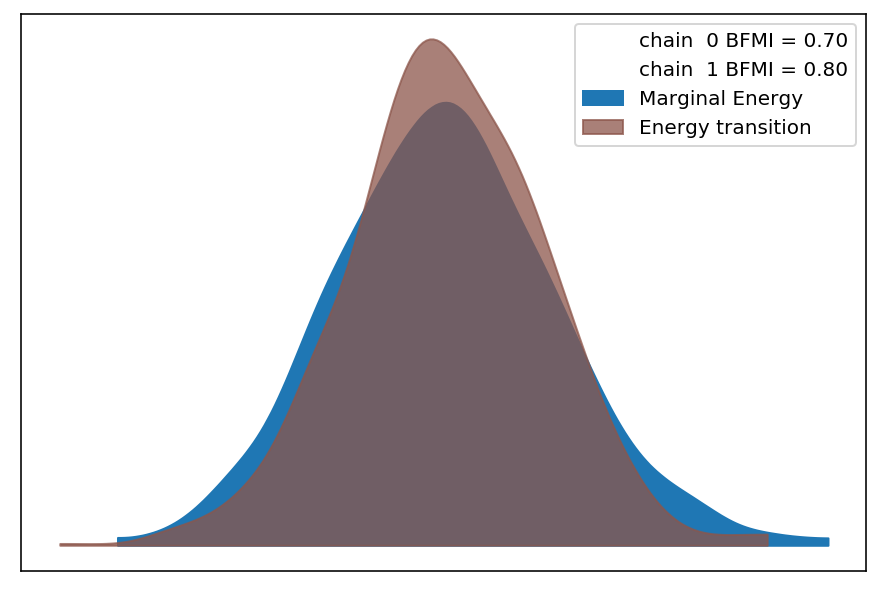

In [45]:
pm.energyplot(trace);

In [46]:
max(np.max(score) for score in pm.gelman_rubin(trace).values())


1.2536776225708108

In [0]:
ps_df = pd.merge(census_df,
                 state_df[['state', 'region_cat']].reset_index(),
                 on='state')

In [48]:
ps_df.head()


,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region,state_initnum,region_cat
0,0,0,0,0,AK,467,21222.0,0.022005,west,0,3
1,0,1,0,0,AK,377,21222.0,0.017765,west,0,3
2,0,2,0,0,AK,419,21222.0,0.019744,west,0,3
3,0,3,0,0,AK,343,21222.0,0.016162,west,0,3
4,0,0,1,0,AK,958,21222.0,0.045142,west,0,3


In [0]:
ps_gender_race = encode_gender_race(ps_df.female, ps_df.race_wbh)
ps_age = ps_df.age_cat.values
ps_edu = ps_df.edu_cat.values
ps_age_edu = encode_age_edu(ps_df.age_cat, ps_df.edu_cat)
ps_region = ps_df.region_cat.values
ps_state = ps_df.state_initnum.values
ps_n = ps_df.freq.values.astype(np.int64)

In [0]:
gender_race_.set_value(ps_gender_race)
age_.set_value(ps_age)
edu_.set_value(ps_edu)
age_edu_.set_value(ps_age_edu)
poll_.set_value(np.zeros_like(ps_gender_race))
state_.set_value(ps_state)
use_poll_.set_value(0)
n_.set_value(ps_n)

In [51]:
with model:
    pp_trace = pm.sample_ppc(trace, random_seed=SEED)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 2000/2000 [00:11<00:00, 168.82it/s]


In [0]:
PP_COLS = ['pp_yes_of_all_{}'.format(i) for i in range(pp_trace['obs'].shape[0])]

pp_df = pd.merge(ps_df,
                 pd.DataFrame(pp_trace['obs'].T, columns=PP_COLS),
                 left_index=True, right_index=True)

In [53]:
pp_df.head()


,race_wbh,age_cat,edu_cat,female,state,freq,freq_state,percent_state,region,state_initnum,region_cat,pp_yes_of_all_0,pp_yes_of_all_1,pp_yes_of_all_2,pp_yes_of_all_3,pp_yes_of_all_4,pp_yes_of_all_5,pp_yes_of_all_6,pp_yes_of_all_7,pp_yes_of_all_8,pp_yes_of_all_9,pp_yes_of_all_10,pp_yes_of_all_11,pp_yes_of_all_12,pp_yes_of_all_13,pp_yes_of_all_14,pp_yes_of_all_15,pp_yes_of_all_16,pp_yes_of_all_17,pp_yes_of_all_18,pp_yes_of_all_19,pp_yes_of_all_20,pp_yes_of_all_21,pp_yes_of_all_22,pp_yes_of_all_23,pp_yes_of_all_24,pp_yes_of_all_25,pp_yes_of_all_26,pp_yes_of_all_27,pp_yes_of_all_28,...,pp_yes_of_all_1960,pp_yes_of_all_1961,pp_yes_of_all_1962,pp_yes_of_all_1963,pp_yes_of_all_1964,pp_yes_of_all_1965,pp_yes_of_all_1966,pp_yes_of_all_1967,pp_yes_of_all_1968,pp_yes_of_all_1969,pp_yes_of_all_1970,pp_yes_of_all_1971,pp_yes_of_all_1972,pp_yes_of_all_1973,pp_yes_of_all_1974,pp_yes_of_all_1975,pp_yes_of_all_1976,pp_yes_of_all_1977,pp_yes_of_all_1978,pp_yes_of_all_1979,pp_yes_of_all_1980,pp_yes_of_all_1981,pp_yes_of_all_1982,pp_yes_of_all_1983,pp_yes_of_all_1984,pp_yes_of_all_1985,pp_yes_of_all_1986,pp_yes_of_all_1987,pp_yes_of_all_1988,pp_yes_of_all_1989,pp_yes_of_all_1990,pp_yes_of_all_1991,pp_yes_of_all_1992,pp_yes_of_all_1993,pp_yes_of_all_1994,pp_yes_of_all_1995,pp_yes_of_all_1996,pp_yes_of_all_1997,pp_yes_of_all_1998,pp_yes_of_all_1999
0,0,0,0,0,AK,467,21222.0,0.022005,west,0,3,273,174,190,172,157,115,218,191,164,158,144,158,124,138,177,102,166,136,185,169,151,175,173,156,159,168,188,166,184,...,128,157,150,179,121,131,155,138,161,174,243,164,151,168,203,220,171,146,148,156,117,233,174,140,196,162,138,216,185,167,176,174,213,167,184,178,152,119,132,192
1,0,1,0,0,AK,377,21222.0,0.017765,west,0,3,99,91,93,93,73,70,103,135,103,73,81,85,52,79,110,65,109,71,97,90,81,121,99,101,95,88,107,97,96,...,91,101,67,109,89,86,96,89,93,75,125,83,73,116,106,137,62,79,68,115,67,132,93,59,94,109,77,112,94,95,113,113,115,102,112,87,98,66,70,113
2,0,2,0,0,AK,419,21222.0,0.019744,west,0,3,57,85,96,77,69,56,80,102,80,72,69,62,53,73,82,58,64,67,87,73,58,100,75,71,79,51,78,82,98,...,53,84,49,88,70,60,66,83,105,91,102,80,55,104,76,129,69,89,70,86,46,120,66,58,83,93,64,90,100,81,108,78,106,101,110,63,92,47,61,90
3,0,3,0,0,AK,343,21222.0,0.016162,west,0,3,50,32,49,36,40,45,18,63,43,14,27,38,29,35,35,37,36,27,51,21,31,35,49,49,47,32,51,22,50,...,26,47,33,45,31,32,39,37,60,40,60,35,52,47,45,69,31,41,31,43,36,68,34,22,49,40,31,56,48,46,51,38,51,35,40,29,46,45,32,44
4,0,0,1,0,AK,958,21222.0,0.045142,west,0,3,349,432,386,345,389,308,351,423,441,329,313,406,332,360,419,333,392,373,385,321,311,329,399,368,368,335,464,316,405,...,270,417,324,394,315,347,335,363,424,467,421,393,392,442,438,518,320,368,350,361,322,423,407,319,393,388,343,405,447,371,372,384,439,386,452,401,346,338,241,496


In [0]:
ps_prob = (pp_df.groupby('state')
                .apply(lambda df: df[PP_COLS].sum(axis=0) / df.freq.sum()))

In [55]:
ps_prob.head()

,pp_yes_of_all_0,pp_yes_of_all_1,pp_yes_of_all_2,pp_yes_of_all_3,pp_yes_of_all_4,pp_yes_of_all_5,pp_yes_of_all_6,pp_yes_of_all_7,pp_yes_of_all_8,pp_yes_of_all_9,pp_yes_of_all_10,pp_yes_of_all_11,pp_yes_of_all_12,pp_yes_of_all_13,pp_yes_of_all_14,pp_yes_of_all_15,pp_yes_of_all_16,pp_yes_of_all_17,pp_yes_of_all_18,pp_yes_of_all_19,pp_yes_of_all_20,pp_yes_of_all_21,pp_yes_of_all_22,pp_yes_of_all_23,pp_yes_of_all_24,pp_yes_of_all_25,pp_yes_of_all_26,pp_yes_of_all_27,pp_yes_of_all_28,pp_yes_of_all_29,pp_yes_of_all_30,pp_yes_of_all_31,pp_yes_of_all_32,pp_yes_of_all_33,pp_yes_of_all_34,pp_yes_of_all_35,pp_yes_of_all_36,pp_yes_of_all_37,pp_yes_of_all_38,pp_yes_of_all_39,...,pp_yes_of_all_1960,pp_yes_of_all_1961,pp_yes_of_all_1962,pp_yes_of_all_1963,pp_yes_of_all_1964,pp_yes_of_all_1965,pp_yes_of_all_1966,pp_yes_of_all_1967,pp_yes_of_all_1968,pp_yes_of_all_1969,pp_yes_of_all_1970,pp_yes_of_all_1971,pp_yes_of_all_1972,pp_yes_of_all_1973,pp_yes_of_all_1974,pp_yes_of_all_1975,pp_yes_of_all_1976,pp_yes_of_all_1977,pp_yes_of_all_1978,pp_yes_of_all_1979,pp_yes_of_all_1980,pp_yes_of_all_1981,pp_yes_of_all_1982,pp_yes_of_all_1983,pp_yes_of_all_1984,pp_yes_of_all_1985,pp_yes_of_all_1986,pp_yes_of_all_1987,pp_yes_of_all_1988,pp_yes_of_all_1989,pp_yes_of_all_1990,pp_yes_of_all_1991,pp_yes_of_all_1992,pp_yes_of_all_1993,pp_yes_of_all_1994,pp_yes_of_all_1995,pp_yes_of_all_1996,pp_yes_of_all_1997,pp_yes_of_all_1998,pp_yes_of_all_1999
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,0.373151,0.382905,0.379936,0.365281,0.371737,0.311281,0.372255,0.441853,0.413674,0.303789,0.288003,0.361040,0.310103,0.327396,0.390303,0.314909,0.348648,0.332815,0.348553,0.320375,0.325982,0.354019,0.388889,0.316417,0.389501,0.328715,0.400999,0.343040,0.398737,0.344595,0.334511,0.276411,0.336867,0.309066,0.359061,0.281500,0.326595,0.375459,0.310857,0.361229,...,0.312883,0.357459,0.318679,0.396334,0.316747,0.354349,0.321318,0.374705,0.385402,0.388418,0.408915,0.360286,0.357506,0.388465,0.398973,0.494817,0.308689,0.354491,0.320941,0.348789,0.323344,0.408444,0.353077,0.277636,0.375318,0.412779,0.349590,0.400339,0.409811,0.364198,0.392376,0.380643,0.431203,0.376355,0.412685,0.350957,0.370606,0.318820,0.291867,0.426633
AL,0.170422,0.173636,0.157457,0.145616,0.226926,0.212091,0.216326,0.213552,0.213796,0.167227,0.164129,0.188856,0.194471,0.196145,0.206929,0.207564,0.188819,0.190915,0.187310,0.179300,0.196316,0.173483,0.232920,0.204075,0.192350,0.194367,0.214566,0.178817,0.229944,0.194122,0.203861,0.155606,0.168009,0.199823,0.171216,0.175005,0.162363,0.183760,0.179055,0.179422,...,0.148909,0.149991,0.145726,0.191544,0.163817,0.204876,0.190133,0.180485,0.173330,0.209727,0.232407,0.200464,0.202804,0.219539,0.150419,0.201778,0.164936,0.165412,0.153651,0.210326,0.175127,0.153027,0.140734,0.145769,0.173636,0.178854,0.189852,0.212183,0.170324,0.190976,0.188220,0.188477,0.212611,0.207924,0.216521,0.211548,0.180131,0.131136,0.169982,0.171711
AR,0.191910,0.161675,0.204140,0.159121,0.247852,0.255096,0.215318,0.222297,0.214368,0.202526,0.214174,0.197723,0.229664,0.220019,0.241568,0.231657,0.236020,0.256700,0.172281,0.160899,0.207727,0.212713,0.254830,0.243325,0.177932,0.229950,0.221316,0.233322,0.202883,0.241425,0.217035,0.185840,0.191859,0.213806,0.204631,0.180823,0.188517,0.166406,0.202168,0.198582,...,0.156464,0.150487,0.140739,0.221020,0.178013,0.227120,0.213724,0.173027,0.169982,0.225884,0.253431,0.178248,0.203691,0.238216,0.138205,0.203752,0.165252,0.188558,0.172894,0.205213,0.200564,0.154758,0.155054,0.153777,0.184767,0.194249,0.173467,0.192145,0.173548,0.198480,0.187117,0.186157,0.218047,0.228530,0.234109,0.231922,0.190346,0.168450,0.170320,0.168991
AZ,0.400570,0.391468,0.397072,0.384070,0.451517,0.378572,0.397683,0.416612,0.413901,0.388116,0.404992,0.391274,0.362484,0.367065,0.417570,0.376026,0.420375,0.404751,0.418170,0.432847,0.373715,0.396219,0.403205,0.382024,0.392661,0.388745,0.409697,0.438951,0.405022,0.403358,0.368946,0.334652,0.3744

In [0]:
ps_mean = ps_prob.mean(axis=1)


In [57]:
ps_mean.head()


state
AK    0.360174
AL    0.188815
AR    0.201390
AZ    0.393169
CA    0.458788
dtype: float64

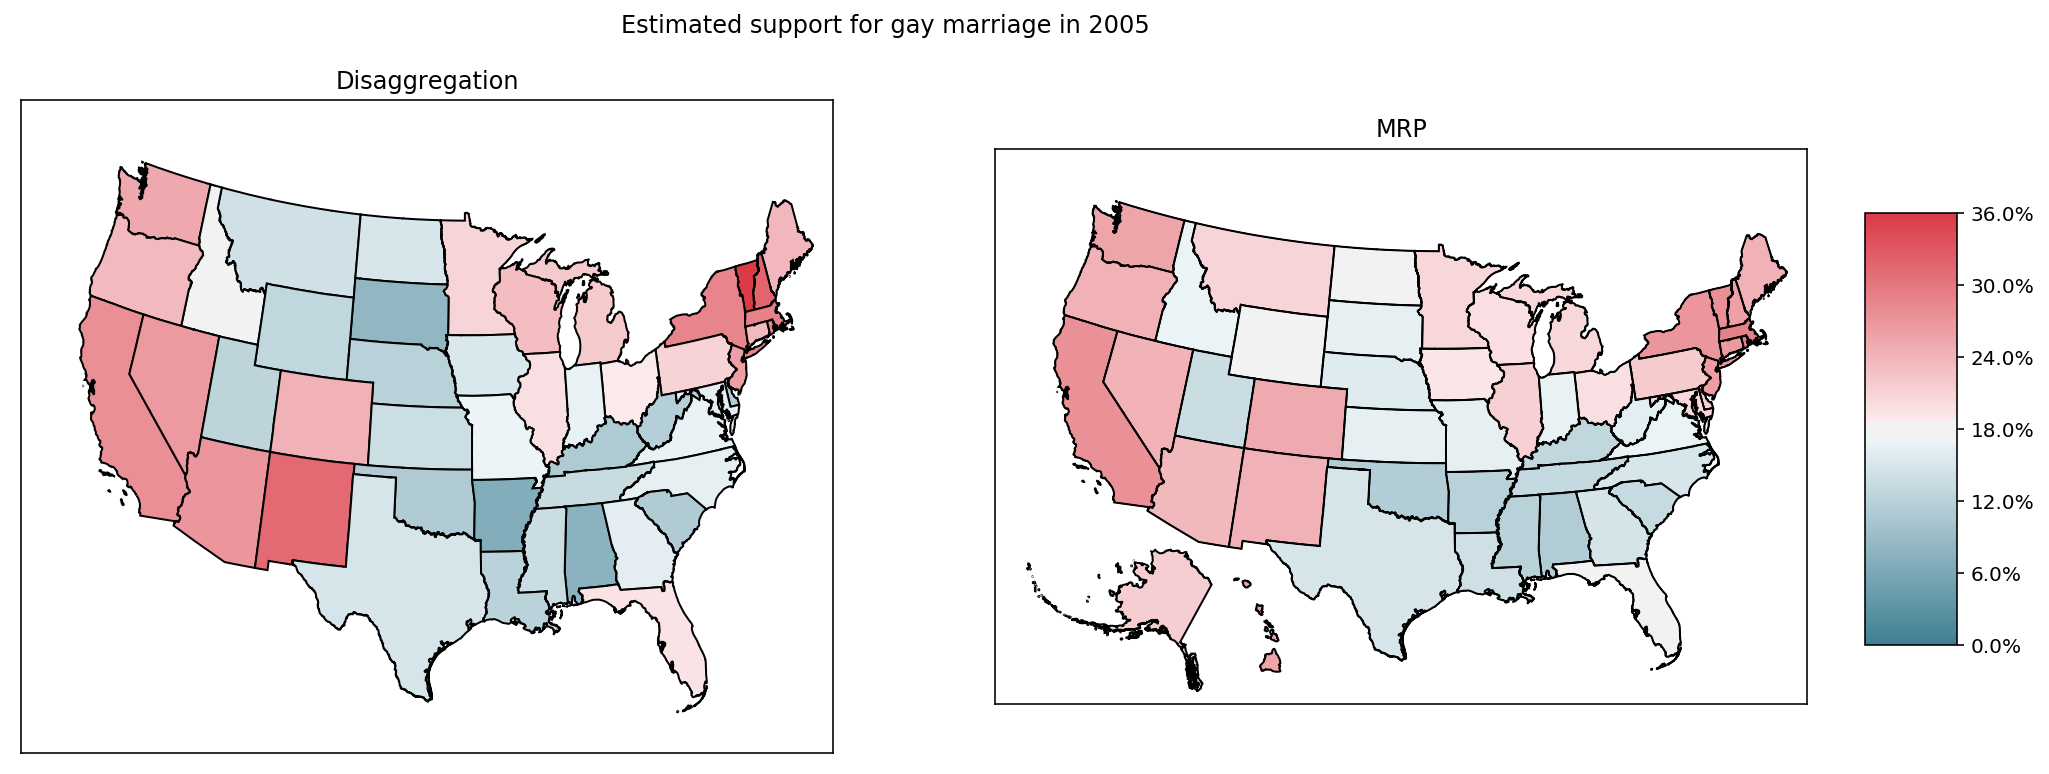

In [58]:
fig, (disagg_ax, mrp_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

fig, disagg_ax, _ = state_plot(disagg_p, p_cmap, p_norm, cbar=False, ax=disagg_ax)
disagg_ax.set_title("Disaggregation");

fig, mrp_ax, cbar_ax = state_plot(ps_mean, p_cmap, p_norm, ax=mrp_ax)
cbar_ax.yaxis.set_major_formatter(p_formatter);
mrp_ax.set_title("MRP");

fig.suptitle("Estimated support for gay marriage in 2005");

In [0]:
disagg_p_aligned, ps_mean_aligned = disagg_p.align(ps_mean)


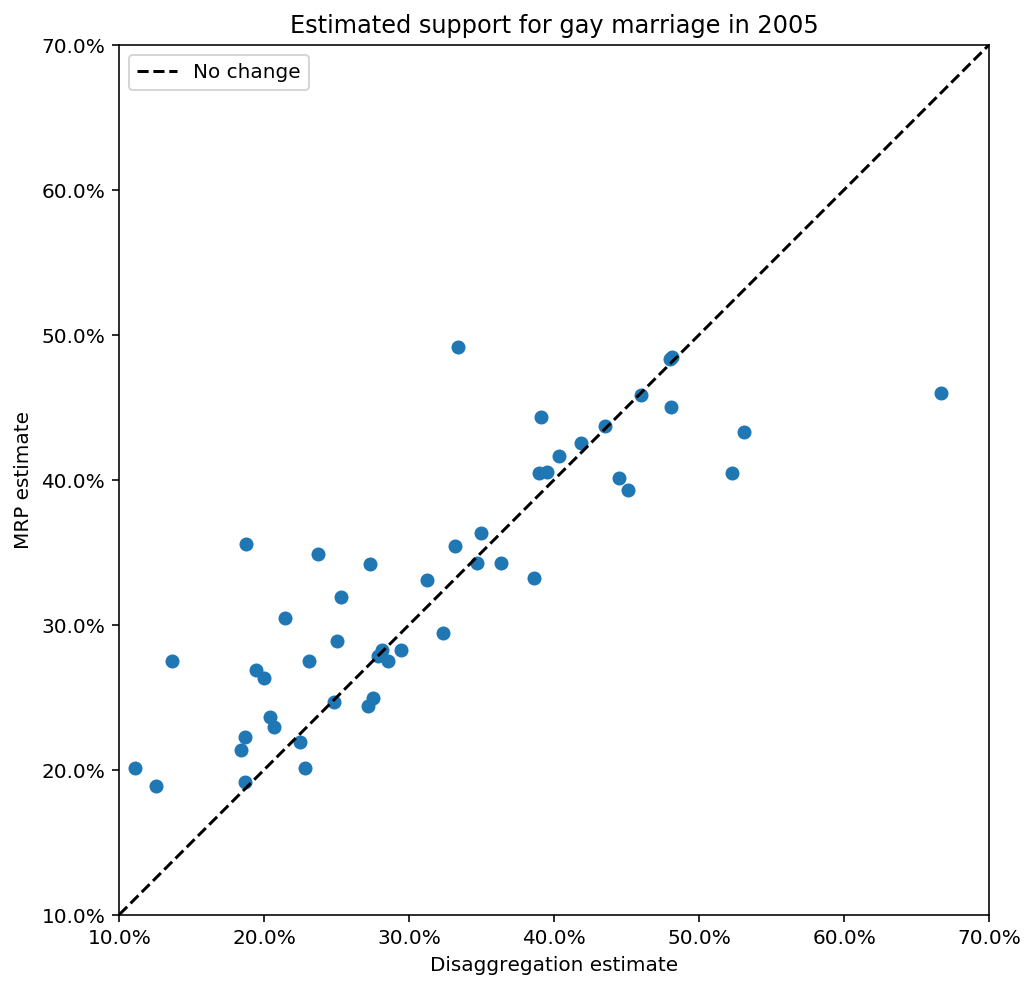

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');

pct_formatter = FuncFormatter(lambda prop, _: '{:.1%}'.format(prop))

ax.plot([0.1, 0.7], [0.1, 0.7], '--', c='k', label="No change");
ax.scatter(disagg_p_aligned, ps_mean_aligned);

ax.set_xlim(0.1, 0.7);
ax.xaxis.set_major_formatter(pct_formatter);
ax.set_xlabel("Disaggregation estimate");

ax.set_ylim(0.1, 0.7);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("MRP estimate");

ax.legend(loc=2);
ax.set_title("Estimated support for gay marriage in 2005");

In [0]:
black_men_disagg_p = (survey_df[(survey_df.race_wbh == 1) & (survey_df.female == 0)]
                               .groupby('state')
                               .yes_of_all
                               .mean())

black_men_ps_mean = (pp_df[(pp_df.race_wbh == 1) & (pp_df.female == 0)]
                         .groupby('state')
                         .apply(lambda df: (df[PP_COLS].sum(axis=0) / df.freq.sum()))
                         .mean(axis=1))

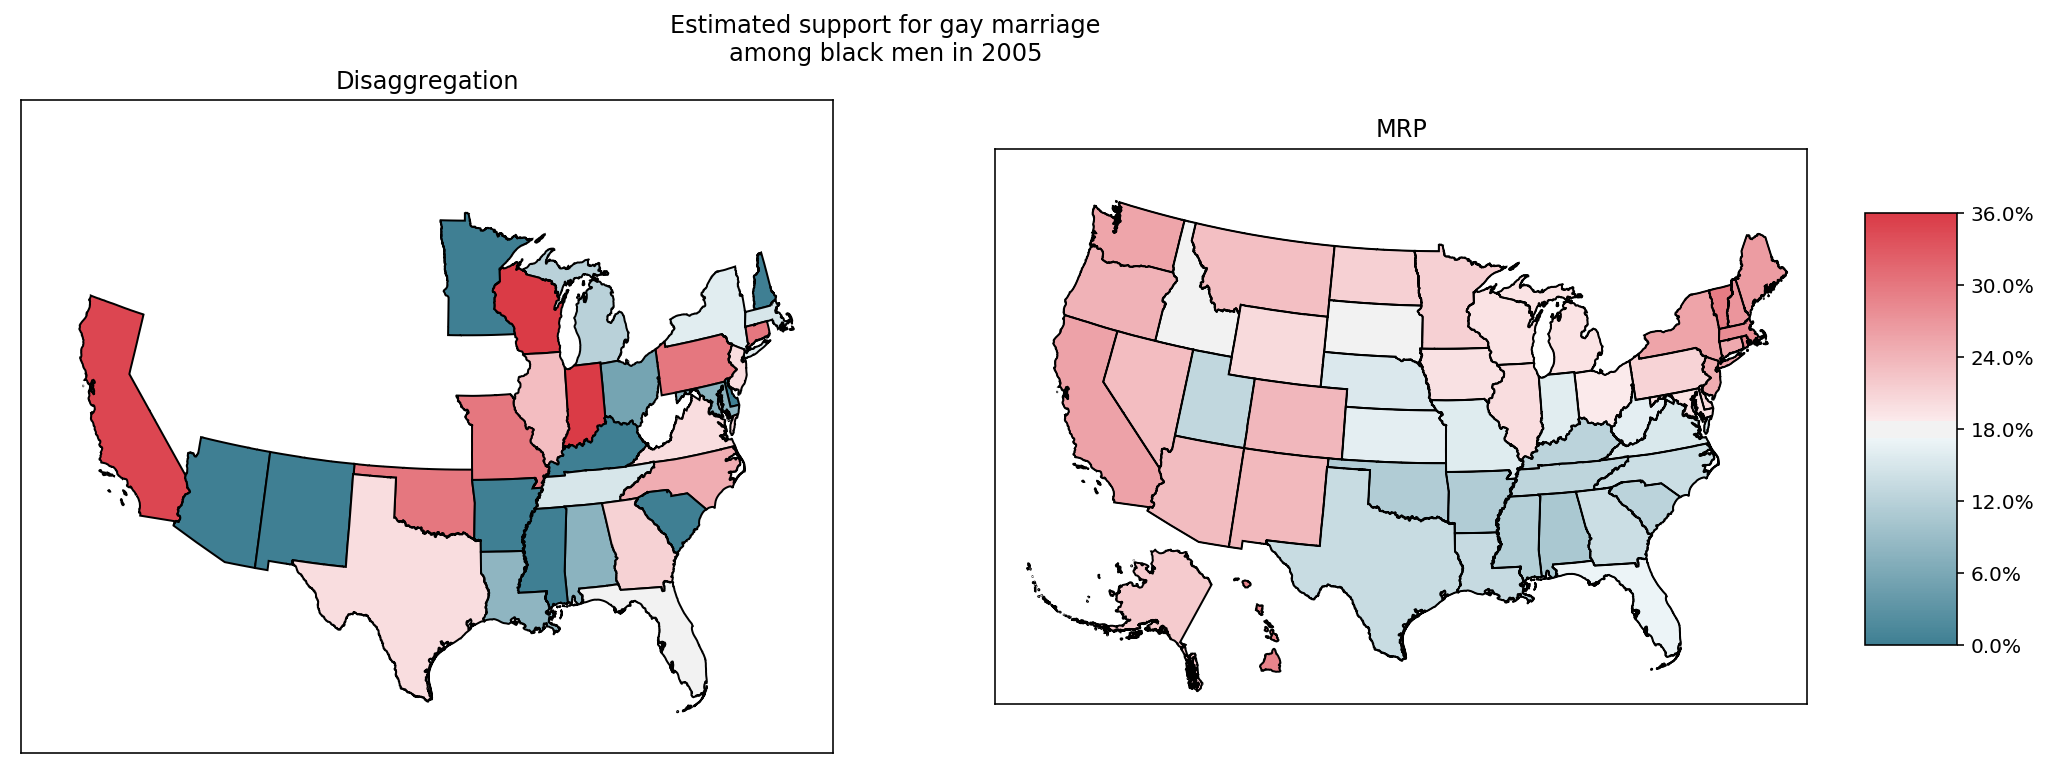

In [62]:
fig, (disagg_ax, mrp_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

fig, disagg_ax, _ = state_plot(black_men_disagg_p, p_cmap, p_norm, cbar=False, ax=disagg_ax)
disagg_ax.set_title("Disaggregation");

fig, mrp_ax, cbar_ax = state_plot(black_men_ps_mean, p_cmap, p_norm, ax=mrp_ax)
cbar_ax.yaxis.set_major_formatter(p_formatter);
mrp_ax.set_title("MRP");

fig.suptitle("Estimated support for gay marriage\namong black men in 2005");

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


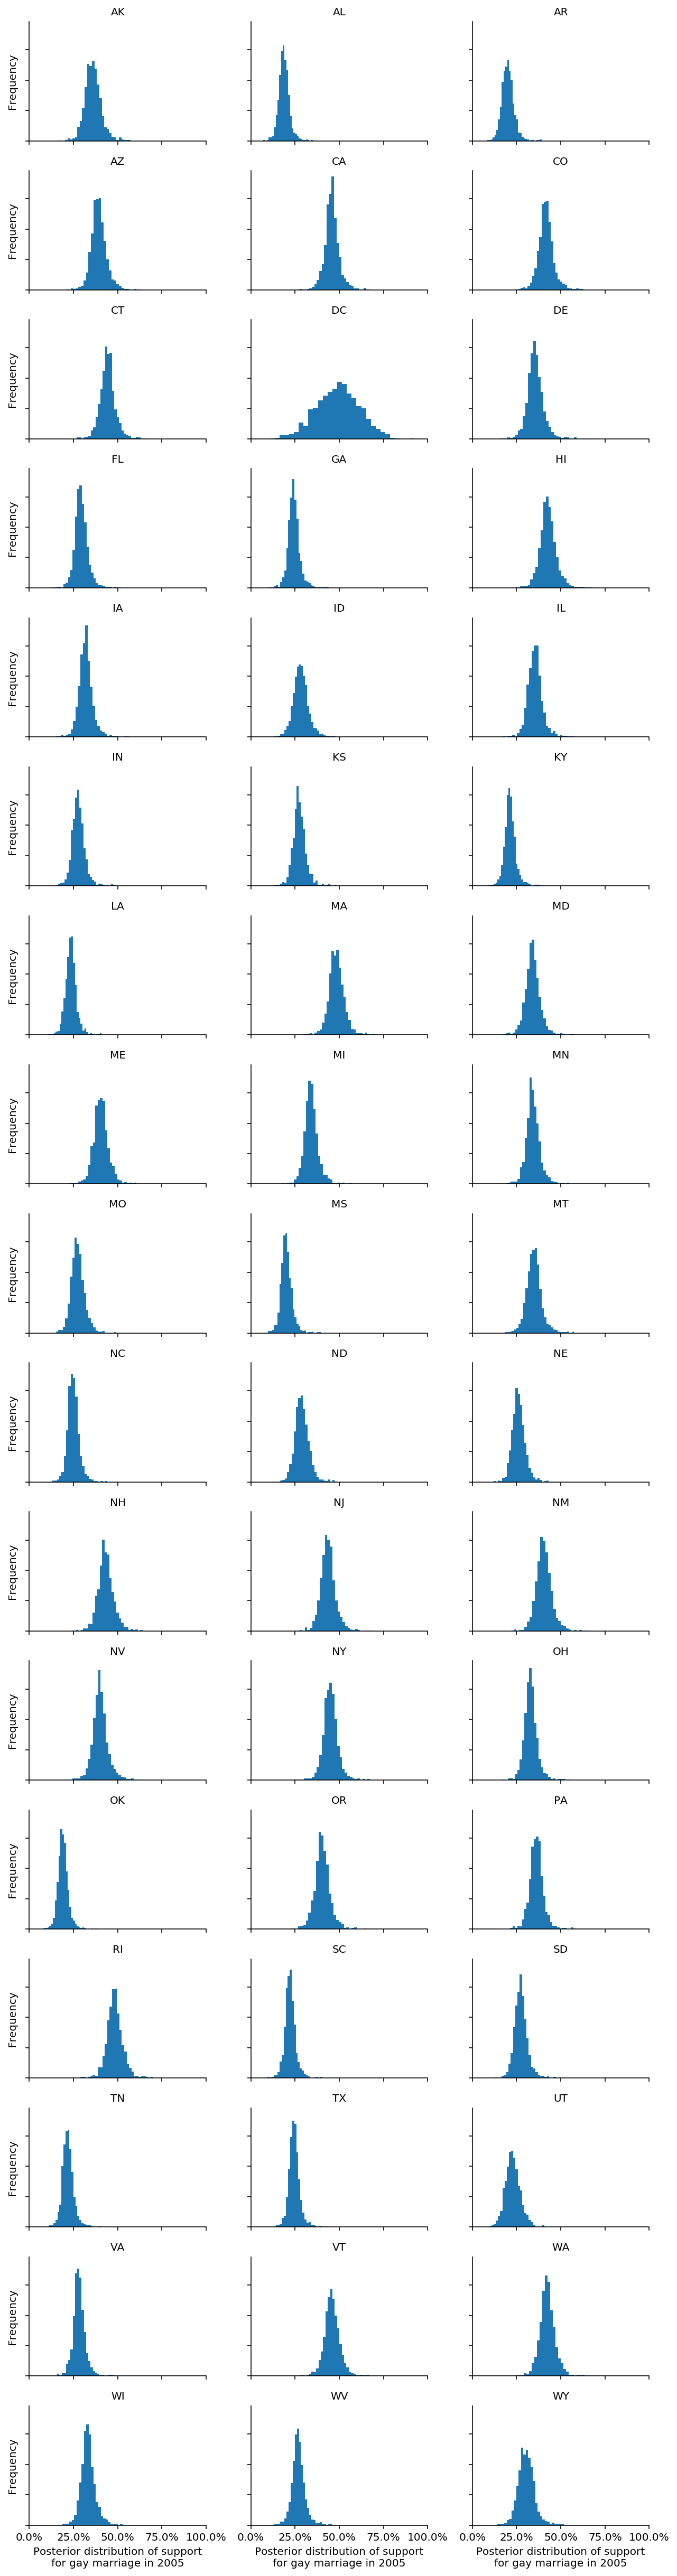

In [64]:
grid = sns.FacetGrid(pd.melt(ps_prob.reset_index(),
                             id_vars='state', value_vars=PP_COLS,
                             var_name='pp_sample', value_name='p'),
                     col='state', col_wrap=3, size=2, aspect=1.5)
grid.map(plt.hist, 'p', bins=30);

grid.set_xlabels("Posterior distribution of support\nfor gay marriage in 2005");

for ax in grid.axes.flat:
    ax.set_xticks(np.linspace(0, 1, 5));
    ax.xaxis.set_major_formatter(pct_formatter);
    plt.setp(ax.get_xticklabels(), visible=True);

grid.set_yticklabels([]);
grid.set_ylabels("Frequency");

grid.fig.tight_layout();
grid.set_titles('{col_name}');